# Imports

In [147]:
%pip install pandas
%pip install seaborn
%pip install sklearn
%pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, se

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import pow
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
sns.set_theme()

# Data Loading & Processing
From the Grim IREC flight

In [149]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)

In [150]:
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048

# Data Analysis
- getting altitude from pressure

In [151]:
boost_end = 3_500
first_charge = 28_125

In [152]:
altim = df[['pressure (kPa)']].copy()

In [153]:
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

Text(0.5, 1.0, 'Measured Altimeter Altitude')

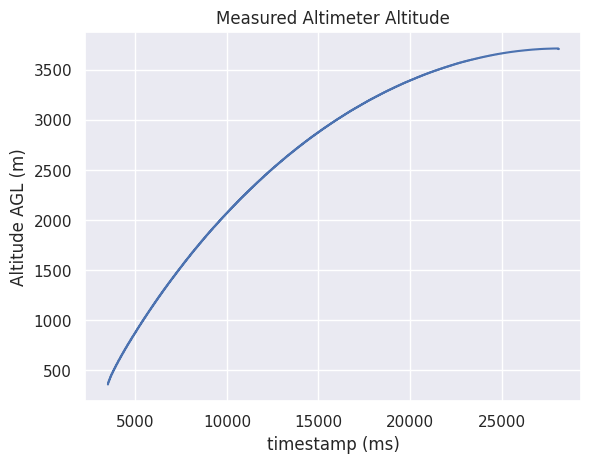

In [154]:
fig = altim.loc[boost_end:first_charge]['alt_m_agl'].plot()
fig.set_ylabel("Altitude AGL (m)")
fig.set_title("Measured Altimeter Altitude")

# Fitting a parabola

In [155]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)

In [156]:
poly = np.polyfit(nice_data.index, nice_data['alt_m_agl'], 2)
print(poly)

def par_fit(x):
    return poly[0] * x * x + poly[1] * x + poly[2]

[  -5.97525396  317.51082755 -540.46277832]


In [157]:
xs = np.linspace(boost_end/1000, first_charge/1000, 1000)

In [158]:
ys = par_fit(xs)

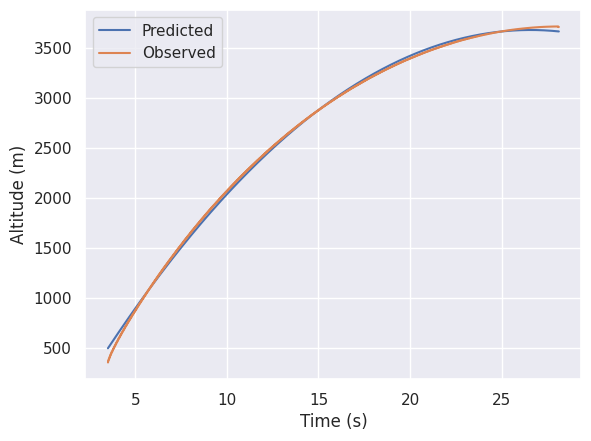

In [159]:
p = sns.lineplot(x=xs, y =ys, label = "Predicted")
p.plot(nice_data['alt_m_agl'], label = "Observed")
p.set_xlabel("Time (s)")
p.set_ylabel("Altitude (m)")
p.legend();

In [160]:
#img%01d.png
def save(in_pattern: str, outfile: str, framerate: int, extra_args: str = ""):
    os.system(f"ffmpeg -framerate {framerate} -i {in_pattern} {extra_args} -y {outfile}")

In [163]:
endpoint_num = 40
endpoints = np.linspace(boost_end/1000+0.1, first_charge/1000, endpoint_num)

In [164]:
apogee_x = nice_data['alt_m_agl'].idxmax()
frame = 0
for end in endpoints:
    data = nice_data.loc[:end]
    all_xs = nice_data.index.to_series()

    poly = np.polyfit(data.index, data['alt_m_agl'], 2)
    predictor = np.poly1d(poly)
    prediction = predictor(all_xs)

    plt.figure(figsize=(16,9))

    p = sns.lineplot(x=all_xs, y =prediction, label = "Predicted Altitude", dashes=(1,1), linewidth=3)
    p.plot(data['alt_m_agl'], label = "Observed Altitude", linewidth=3, alpha = 0.75, c='C2')

    p.set_xlim(0, 32)
    p.set_ylim(0, 4000)

    p.set_xlabel("Time (s)")
    p.set_ylabel("Altitude (m)")

    predicted_apogee = all_xs.iloc[prediction.argmax()]

    p.axvline(apogee_x, c='C3', label = f"Actual Apogee: {apogee_x:.2f}s", dashes=(2,2))
    p.axvline(predicted_apogee, label = f"Predicted Apogee: {predicted_apogee:.2f}s", c= 'C4', dashes=(2,2))
    
    r2 = r2_score(data['alt_m_agl'], prediction[:len(data)])
    p.get_figure().suptitle(f"Grim Altimeter Parabola Fitting: T+{end:.2f}s")
    
    p.set_title(f"{poly[0]:.2f}x^2 + {poly[1]:.2f}x + {poly[2]:.2f}        R^2 = {r2:.5f}")
    p.legend(loc="upper left")
    
    plt.savefig(f"intermediate_data/stepped_fitting/{frame:03}.png");
    plt.close()

    frame+=1

In [166]:
# save("intermediate_data/stepped_fitting/%03d.png" , "intermediate_data/ParabolaFallingShort.mp4", 60, extra_args = "-vf tpad=stop_mode=clone:stop_duration=2")

In [167]:
pred_data = data.copy()

In [168]:
pt2_ind = 50
delta_pos = pred_data.iloc[pt2_ind] - pred_data.iloc[0]
delta_t = pred_data.iloc[pt2_ind].name - pred_data.iloc[0].name
initial_velocity = delta_pos / delta_t
initial_pos = pred_data.iloc[0]

In [213]:
def projectile(realt):
    t = realt-boost_end/1000
    return initial_pos['alt_m_agl'] + initial_velocity['alt_m_agl'] * t - .5 * 9.8 * t * t

In [214]:
pred_data['projectile_m_agl'] = pred_data.index.to_series().map(projectile)

In [215]:
renamed = pred_data[['projectile_m_agl', 'alt_m_agl']].rename(columns={"alt_m_agl":"Altitude AGL", "projectile_m_agl": "Projectile Prediction"})

Text(0, 0.5, 'Altitude (m)')

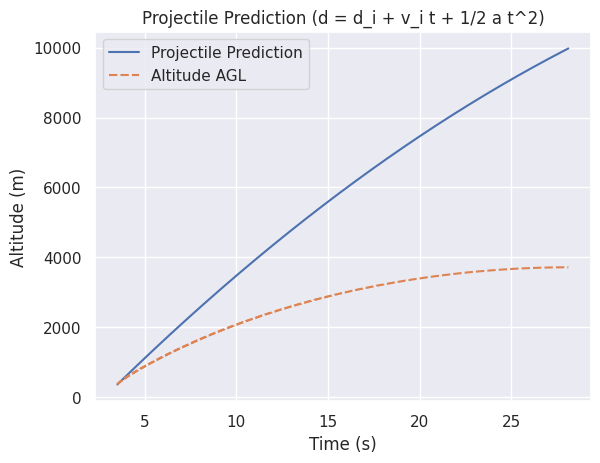

In [216]:
p = sns.lineplot(renamed)
p.set_title("Projectile Prediction (d = d_i + v_i t + 1/2 a t^2)")
p.set_xlabel("Time (s)")
p.set_ylabel("Altitude (m)")
